In [1]:
import os
from dotenv import load_dotenv, find_dotenv

from datetime import datetime
from collections import OrderedDict, defaultdict

import sys
from pathlib import Path, PurePath as PPath

print('Python ver: {}\nPython env: {}'.format(sys.version, Path(sys.prefix).name))
print('Currrent dir: {}\n'.format(Path.cwd()))

def add_to_sys_path(this_path, up=False):
    """
    Prepend this_path to sys.path.
    If up=True, path refers to parent folder (1 level up).
    """
    if up:
        # NB: Path does not have a str method.
        newp = str(PPath(this_path).parent)
    else:
        newp = str(PPath(this_path)) 
    
    if newp not in sys.path:
        sys.path.insert(1, newp)
        print('Path added to sys.path: {}'.format(newp))

# if notebook inside another folder, eg ./notebooks:
nb_folder = 'notebooks'
add_to_sys_path(Path.cwd(), Path.cwd().name.startswith(nb_folder))


def get_project_dirs(which=['data', 'images'], nb_folder='notebooks'):
    dir_lst = []
    if Path.cwd().name.startswith(nb_folder):
        dir_fn = Path.cwd().parent.joinpath
    else:
        dir_fn = Path.cwd().joinpath
        
    for d in which:
        DIR = dir_fn(d)
        if not DIR.exists():
            Path.mkdir(DIR)
        dir_lst.append(DIR)
    return dir_lst

DIR_DATA, DIR_IMG = get_project_dirs()

DATA_SHAPEFILES = DIR_DATA.joinpath('shapefiles')
DATA_RAW = DIR_DATA.joinpath('raw')
DATA_INTERIM = DIR_DATA.joinpath('intermediate')
DATA_READY = DIR_DATA.joinpath('production')

def data_subfolders():
    ans = int(input('Setup data subfolders?  1=yes, 0=no: '))
    if ans == 1:
        for d in [DATA_RAW, DATA_INTERIM, DATA_READY, DATA_SHAPEFILES]:
            if not d.exists():
                Path.mkdir(d)
                print(f'Created: {d}')
                
import numpy as np
import scipy as sp
from scipy import stats as sps
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option("display.max_colwidth", 300)

import json

import matplotlib as mpl
from matplotlib import pyplot as plt
plt.ion()
# color cycler too short (< weekdays) w/ seaborn 
plt.style.use(['tableau-colorblind10', 'fast'])

from pprint import pprint as pp

# Filtered dir() for method discovery:
def filter_dir(obj, start_with_str='_', exclude=True):
    return [d for d in dir(obj) if not d.startswith(start_with_str) == exclude]

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display, Image, HTML, Markdown #, IFrame
# for presentations:
#display(HTML("<style>.container { width:100% !important; }</style>"))

Markdown( """**First code cell from custom template `dsml.ipynb`**. 
_See Tim Paine's [jupyter_lab templates extention](https://github.com/timkpaine/jupyterlab_templates)._<br>
""")

def new_section(title='New section'):
    style = "text-align:center;background:#c2d3ef;padding:16px;color:#ffffff;font-size:2em;width:98%"
    return HTML('<div style="{}">{}</div>'.format(style, title))


def add_div(div_class='info', div_start='>', div_text='', output_string=True):
    from IPython import get_ipython
    from IPython.display import HTML, Markdown
    """
    Behaviour with default `output_string=True`:
    The cell is overwritten with the output string, but the cell mode is still in 'code' not 'markdown':
    ```
    In [x]
    add_div('warning', 'Tip: ', 'some tip here', output_string=True)
    In [x]
    <div class="alert alert-warning"><b>Tip: </b>some tip here</div>
    ```
    The only thing to do is change the cell mode to Markdown.
    If `output_string=False`, the HTML output is displayed in an output cell.
    """
    accepted = ['info', 'warning', 'danger']
    
    if div_class not in accepted:
        return HTML(f"""<div class="alert"><b>Wrong class:</b> `div_start` is one of {accepted}.
                    </div>""")
    
    div = f"""<div class="alert alert-{div_class}"><b>{div_start}</b>{div_text}</div>"""
    if output_string:
        return get_ipython().set_next_input(div, 'markdown')
    else:
        return Markdown(div) #HTML(div)

    
# autoreload extension
from IPython import get_ipython
ipython = get_ipython()

if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

Python ver: 3.6.7 (default, Feb 28 2019, 07:28:18) [MSC v.1900 64 bit (AMD64)]
Python env: dsml
Currrent dir: C:\Users\catch\Documents\GH_Projects\NYC_data

Path added to sys.path: C:\Users\catch\Documents\GH_Projects\NYC_data


In [4]:
data_subfolders()

Setup data subfolders?  1=yes, 0=no:  0


---
---
# NYC OpenData - Arrests Dataset
---

# Import sodapy api and local etl util libraries, and credentials from `.env` file

In [2]:
import sodapy
SODA_VER = '2.1'

# local utils lib
import etl
from display_figure import display_figure

# load variables from APIs user account(s):
# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

if dotenv_path == '':
    print("""Local '.env' file not found:\n\tThe Socrata credential variables are set to None, 
    which may not be accepted.\n\tIf that's the case, create the file with the credentials as KEY=value on each line.""")
else:
    # load up the entries as environment variables
    load_dotenv(dotenv_path)
    
    #GOOGLE_KEY = os.getenv("GOO_GEO_API_1")
    SODA_U = os.environ.get('SODA_U')
    SODA_P = os.environ.get('SODA_P')
    SODA_SECRET = os.environ.get('SODA_SECRET')
    SODA_APP_TOKEN=os.environ.get('SODA_APP_TOKEN')

True

## File naming convention: DatasetID_name.ext

# Initialize sodapy.Socrata client for the NYC data domain:

In [3]:
SODA_NYC = 'data.cityofnewyork.us'
cli_NYC = sodapy.Socrata(SODA_NYC, SODA_APP_TOKEN, username=SODA_U, password=SODA_P)

maxlim = 500_000
ID_Arrests = '8h9b-rp9u'

<div class="alert alert-info"><b>Population data</b></div>

# Population in the 2 precincts

I used https://popfactfinder.planning.nyc.gov/#13.35/40.76876/-73.95531 and found out that the boundaries of precincts of interests are the same as that of the Community Districts.  

Thus I retrieve the latest population counts (2010) from the Cit of New York dataset: "City-Government/New-York-City-Population-By-Community-Districts", with ID "xi7c-iiu2"

In [4]:
# pop by Community District (CD):

ID_CD_pop = 'xi7c-iiu2'

pops = DATA_RAW.joinpath(ID_CD_pop + '_CD_pop_2010.csv')

<div class="alert alert-info"><b>METADATA Analysis</b></div>

In [6]:
ID_Arrests = '8h9b-rp9u'

raw_meta = DATA_RAW.joinpath(ID_Arrests + '_Audit_medadata.json')
raw_dataset = DATA_RAW.joinpath(ID_Arrests + '.csv')

# 1st intermediate: Dropped: arrest_date:1->Y M D; ky_cd:4, ofns_desc:5-> redundant with pd_cd & pd_desc
dataset1 = DATA_INTERIM.joinpath(ID_Arrests + '_1.csv')

# 2nd interm: cleaned up to age_group
dataset2 = DATA_INTERIM.joinpath(ID_Arrests + '_2.csv')


# precinct/boro/max_lat min_lon dict as csv
precinct_boro_geo = DATA_INTERIM.joinpath(ID_Arrests + '_precinct_boro_geo.csv')

# cleaned:
data_clean = DATA_READY.joinpath(ID_Arrests + '.csv')

### Dataset Rows

In [7]:
# load from local json file:

with open(raw_meta) as fh:
    meta_Arrests = json.load(fh)

# Dataset full name, Total row count (raw data):
dataset_name = meta_Arrests['name']

dataset_rows = etl.get_rows_from_metadata(meta_Arrests, ID_Arrests)

print(f'Metadata info:\n{dataset_name} - Complete dataset rows: {dataset_rows:,}')

Metadata info:
NYPD Arrests Data (Historic) - Complete dataset rows: 4,798,339


### Dataset colophon

In [8]:
# This bit of info can be embedded in the final report:
colophon = DATA_READY.joinpath(ID_Arrests + '_colophon.csv')

In [9]:
df_colo = pd.read_csv(colophon, index_col=0)
df_colo

,Dataset info
Dataset Name,NYPD Arrests Data (Historic)
Dataset Identifier,8h9b-rp9u
Total Rows,"4,798,339"
Source Domain,data.cityofnewyork.us
Created,2018-06-05 20:04:11
Last Updated,2019-05-16 18:08:26
Category,Public Safety
Attribution,Police Department (NYPD)
Owner,NYC OpenData
Endpoint Version,2.1


### First glance at the overall data quality:

In [10]:
metainfo_file = DATA_RAW.joinpath(ID_Arrests + '_Audit_metainfo.csv')

# Already saved?
if metainfo_file.exists():
    nyc_meta_col_df = pd.read_csv(metainfo_file, index_col=0)
else:
    nyc_meta_col_df = etl.get_dataset_metainfo(meta_Arrests, ID_Arrests)
    nyc_meta_col_df.to_csv(metainfo_file)

# Time span:
span = etl.get_dataset_span_from_meta(nyc_meta_col_df, 'ARREST_DATE')

# Year list:
years = [y for y in range(span[0], span[1]+1)]
last4years = years[-4:]

text = '#### Metadata info: Complete dataset time span in years ({} to {}): {}\n'.format(span[0], span[1], span[1] - span[0])
Markdown(text)

nyc_meta_col_df

#### Metadata info: Complete dataset time span in years (2006 to 2018): 12


,Largest,Smallest,Null,Not null,Null%
ARREST_KEY,9961669,10003438,0,4798339,0.0
ARREST_DATE,2018-12-31T00:00:00.000,2006-01-01T00:00:00.000,0,4798339,0.0
PD_CD,997.0,0.0,220,4798119,0.0
PD_DESC,"WOUNDS,REPORTING OF","A.B.C.,FALSE PROOF OF AGE",8870,4789469,0.2
KY_CD,995,101,8870,4789469,0.2
OFNS_DESC,VEHICLE AND TRAFFIC LAWS,ABORTION,8870,4789469,0.2
LAW_CODE,WC 0220001,ABC00000MA,196,4798143,0.0
LAW_CAT_CD,V,F,16103,4782236,0.3
ARREST_BORO,S,B,8,4798331,0.0
ARREST_PRECINCT,123,1,0,4798339,0.0


<div class="alert alert-info"><b>Complete dataset with split date: M and DoW</b></div>

Dataset downloaded manually from:
    https://data.cityofnewyork.us/Public-Safety/NYPD-Arrests-Data-Historic-/8h9b-rp9u/data - > 8h9b-rp9u_manual.csv (no transformed date fields)

---
# Cleaning
#### First read:

---
#### Second read:

#### check record w/ 'PL ' in law_code: Could be use for imputation of pd_code:

#### check uncategorized records & determine if imputation is possible

#### Audit uncategorized arrests before deleting: Top3 precincts w/ uncategorized arrests: 14 (53), 103 (10) and 73 (6): 69 out of 220: over 31% 

#### Delete uncategorized

#### jurisdiction_code
> Jurisdiction responsible for arrest. Jurisdiction codes 0(Patrol), 1(Transit) and 2(Housing) represent NYPD whilst codes 3 and more represent non NYPD jurisdictions

#### Imputation: jurisdiction_code: 10 recs changed nan to 3:: outside nyc + type cast to int

#### age groups

#### Replace NaN in age_group to UNKNOWN

#### Valid vs invalid age_group: what info?

#### Before trying regex next, save df1 -> df2 first

#### Obtain the invalid set by set difference on indices
> **Index.difference(self, other, sort=None)**:  Return a new Index with elements from the index that are not in _other_.
#### Imputation heuristics: impute most common age group to missing values if ratio (invalid / valid) < 5%.

### Assign 8 missing arrest_boros with precinct boro

#### Save final

---
---

<div class="alert alert-info"><b>Clean dataset</b></div>

In [61]:
# reopen

data = pd.read_csv(data_clean, index_col=0)
data_rows = data.shape[0]
data.head()

C:\Users\catch\Anaconda3\envs\dsml\lib\site-packages\numpy\lib\arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,arrest_key,pd_cd,pd_desc,law_code,law_cat_cd,arrest_boro,arrest_precinct,jurisdiction_code,age_group,perp_sex,perp_race,x_coord_cd,y_coord_cd,latitude,longitude,Year,Month,DoW
1,173130602,54,"MARIJUANA, POSSESSION",PL 2210500,V,Q,105,0,25-44,M,BLACK,1063056.0,207463.0,40.735772,-73.715638,2017,12,0
2,173114463,222,"THEFT OF SERVICES, UNCLASSIFIED",PL 1651503,M,Q,114,0,25-44,M,ASIAN / PACIFIC ISLANDER,1009113.0,219613.0,40.769437,-73.910241,2017,12,0
3,173113513,81,"NY STATE LAWS,UNCLASSIFIED VIOLATION",LOC000000V,V,K,73,1,18-24,M,BLACK,1010719.0,186857.0,40.679525,-73.904572,2017,12,0
4,173113423,101,ASSAULT 3,PL 1200001,M,M,18,0,25-44,M,WHITE,987831.0,217446.0,40.763523,-73.987074,2017,12,0
5,173113421,101,ASSAULT 3,PL 1200001,M,M,18,0,45-64,M,BLACK,987073.0,216078.0,40.759768,-73.989811,2017,12,0


#### Unresolved issues (most important: no pd_desc)

In [490]:
na_cat_law_msk = data['law_cat_cd'].isna()
n_na_cat_law = data[na_cat_law_msk].shape[0]
print(f'Records without law_cat_cd: {n_na_cat_law:,}'')
      
na_pd_desc_mask = data['pd_desc'].isna()
n_na_pd_desc = data[na_pd_desc_mask].shape[0]
print(f'Records without pd_desc: {n_na_pd_desc:,}\n\tYearly counts:')

data[na_pd_desc_mask].groupby('Year')['arrest_key'].count()

8650

Year
2006      12
2007      14
2008     135
2009     249
2010     634
2011     720
2012    1236
2013    1146
2014     940
2015     970
2016     931
2017     807
2018     856
Name: arrest_key, dtype: int64

15907

In [492]:
Markdown(f'<h2> Deleted rows: {dataset_rows - data_rows}; clean data_rows: {data_rows:,}<br>There are still {n_na_pd_desc} recs without pd_desc.')

<h2> Deleted rows: 220; clean data_rows: 4,798,119<br>There are still 8650 recs without pd_desc.

---
---

<div class="alert alert-info"><b>Arrests counts</b></div>

In [13]:
in_YMD_15 = DATA_INTERIM.joinpath(ID_Arrests + '_2015_YMD.csv')
in_YMD_16 = DATA_INTERIM.joinpath(ID_Arrests + '_2016_YMD.csv')
in_YMD_17 = DATA_INTERIM.joinpath(ID_Arrests + '_2017_YMD.csv')
in_YMD_18 = DATA_INTERIM.joinpath(ID_Arrests + '_2018_YMD.csv')

in_YMD_counts = DATA_INTERIM.joinpath(ID_Arrests + '_all_YMD.csv')

xtab_2015 = DATA_INTERIM.joinpath(ID_Arrests + '_2015_YMD_xtab.csv')
xtab_2016 = DATA_INTERIM.joinpath(ID_Arrests + '_2016_YMD_xtab.csv')
xtab_2017 = DATA_INTERIM.joinpath(ID_Arrests + '_2017_YMD_xtab.csv')
xtab_2018 = DATA_INTERIM.joinpath(ID_Arrests + '_2018_YMD_xtab.csv')

# Yearly counts:

### No hour information in this dataset: datetimestamp field uses date only => hour = 0.

In [421]:
#df_all_counts = etl.get_period_yearly_count(data, years, local_file=in_YMD_counts, replace=True)
df_all_counts = etl.load_xtab_df(in_YMD_counts,)
df_all_counts

,Year,Total
0,2006,371872
1,2007,403192
2,2008,401507
3,2009,421307
4,2010,422315
5,2011,412851
6,2012,396276
7,2013,393809
8,2014,387727
9,2015,339470


In [428]:
((df_all_counts.loc[12,'Total'] - df_all_counts.loc[11, 'Total'])/df_all_counts.loc[11,'Total'] +
(df_all_counts.loc[11,'Total'] - df_all_counts.loc[10, 'Total'])/df_all_counts.loc[10,'Total'] +
(df_all_counts.loc[10,'Total'] - df_all_counts.loc[9, 'Total'])/df_all_counts.loc[9,'Total'] ).mean()

-0.3015169957864169

In [429]:
(df_all_counts.loc[12,'Total'] - df_all_counts.loc[11, 'Total'])/df_all_counts.loc[11,'Total']
(df_all_counts.loc[11,'Total'] - df_all_counts.loc[10, 'Total'])/df_all_counts.loc[10,'Total']
(df_all_counts.loc[10,'Total'] - df_all_counts.loc[9, 'Total'])/df_all_counts.loc[9,'Total']

-0.1380766879203424

-0.09095673052492505

-0.07248357734114944

In [14]:
#test
year = 2015

MDxt_15 = etl.load_xtab_df(xtab_2015, colindex_name='Month')
MDxt_15_styl = etl.highlights_styled(MDxt_15)

Markdown(f"<h3>Total number of arrests per day and month in {year}</h3>(Monthly min: green, max: orange.)")
MDxt_15_styl

year = 2018

MDxt_18 = etl.load_xtab_df(xtab_2018, colindex_name='Month')
MDxt_18_styl = etl.highlights_styled(MDxt_18)

Markdown(f"<h3>Total number of arrests per day and month in {year}</h3>(Monthly min: green, max: orange.)")
MDxt_18_styl

<h3>Total number of arrests per day and month in 2015</h3>(Monthly min: green, max: orange.)

Month,1,2,3,4,5,6,7,8,9,10,11,12
Day,,,,,,,,,,,,
Sun,2032,2620,3505,2592,3293,2795,2946,3713,2739,2692,3097,2410
Mon,2152,2499,3919,3051,2824,3663,3003,3803,2823,3029,3616,2794
Tue,3416,4171,4967,4460,4168,5079,4214,4430,5378,4225,4003,4809
Wed,4298,4990,4925,5924,4676,4486,5951,5121,5714,4036,4388,4373
Thu,4792,4864,4317,5900,4486,4716,5607,4785,4264,5742,3341,3645
Fri,4759,4281,4373,4306,4778,4309,4973,4571,4032,5101,4092,3166
Sat,3889,3651,4001,3725,4418,3634,3495,4915,3775,4153,3526,3276


<h3>Total number of arrests per day and month in 2018</h3>(Monthly min: green, max: orange.)

Month,1,2,3,4,5,6,7,8,9,10,11,12
Day,,,,,,,,,,,,
Sun,2203,2043,2263,2554,2061,1826,2619,2206,2293,1858,1859,2103
Mon,3273,2687,2593,2875,2300,2275,2976,2319,2115,2753,2131,2280
Tue,4381,3530,3467,3201,3746,2896,3642,2909,2608,3555,2634,2356
Wed,4764,3668,2795,3484,4293,3169,3026,4066,3017,3751,2872,2687
Thu,3261,3913,4268,3479,4031,3079,3144,3834,2884,2924,3260,2652
Fri,3211,3137,3727,3051,3193,3382,2899,3619,2732,2642,3144,2483
Sat,2789,2746,3349,2683,2412,2985,2569,2427,2859,2024,2096,2834


### Bar plots: easier to read?

In [15]:
fig_xtab_15 = DIR_IMG.joinpath(ID_Arrests + '_2015_xtab_YMDt.png') 
fig_xtab_16 = DIR_IMG.joinpath(ID_Arrests + '_2016_xtab_YMDt.png') 
fig_xtab_17 = DIR_IMG.joinpath(ID_Arrests + '_2017_xtab_YMDt.png') 
fig_xtab_18 = DIR_IMG.joinpath(ID_Arrests + '_2018_xtab_YMDt.png') 

In [16]:
def save_xtab_barplots(year):
    """
    Wrapper for etl.show_bar_plot with savepic=False to add title,
    quickly visualize best legend postion then save.    
    """
    fig_name = DIR_IMG.joinpath(ID_Arrests + f'_{year}_xtab_YMDt.png') 
    # 't'in name: transposed df
    xtab_name = DATA_INTERIM.joinpath(ID_Arrests + f'_{year}_YMD_xtab.csv')
    
    fsize = (10,5)
    fig, ax = plt.subplots(1, 1, figsize=fsize)

    bbox = (0.05, 1.0, 0.9, .02)
    mode = 'expand'
    
    dfxt = etl.load_xtab_df(xtab_name)
    
    # reset column index name: in the way whith expand mode:
    dfxt.columns.name=None
    dfxt.index.name=None

    ax = etl.show_bar_plot(dfxt.T, ax, fname=fig_name, 
                           lgd_bbox=bbox, lgd_mode=mode,
                           savepic=False, replace=True, alpha=0.85, width=.70);
    
    plt.suptitle(str(year), fontweight='bold');
    
    etl.save_pic(plt, fname=fig_name, replace=True)
    plt.close(fig);

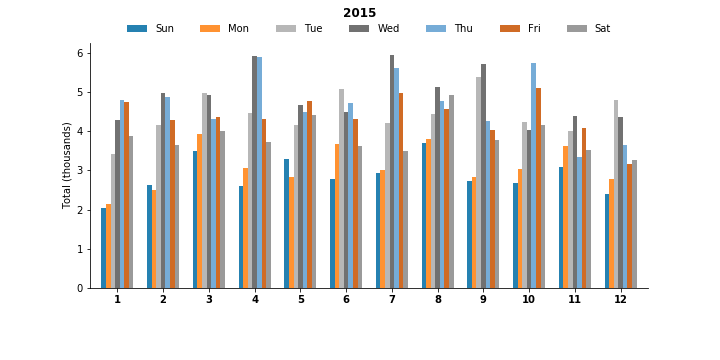

In [410]:
Image(filename=fig_xtab_15)

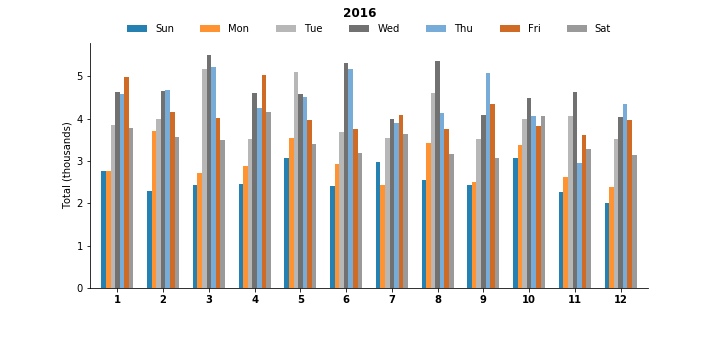

In [411]:
Image(filename=fig_xtab_16)

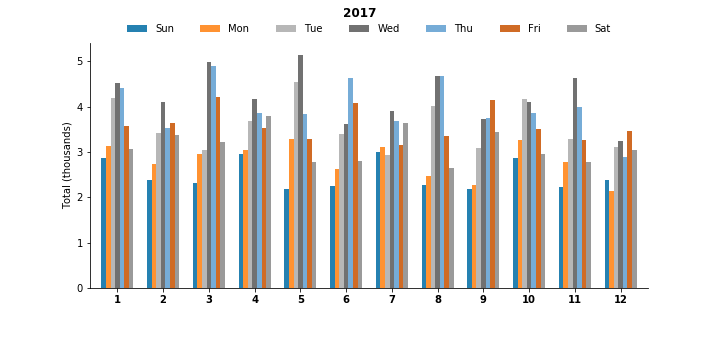

In [412]:
Image(filename=fig_xtab_17)

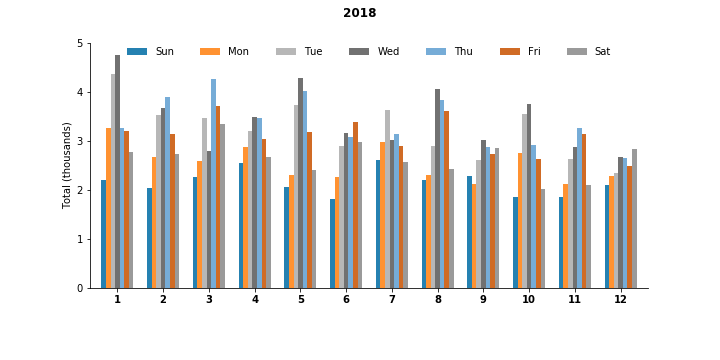

In [413]:
Image(filename=fig_xtab_18)

---

### All years count

In [17]:
all_counts_pic = DIR_IMG.joinpath(ID_Arrests + '_years_counts_all.png')

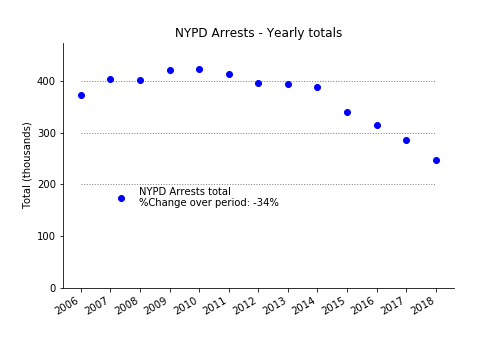

In [493]:
Image(filename=all_counts_pic)

---
# Questions

In [385]:
Questions = {'Q1': "Has the arrest rate been decreasing from 2015-2018?",
             'Q2': "What are the top 5 most frequent arrests as described in the column 'pd_desc' in 2018?",
             'Q3': "If we think of arrests as a sample of total crime, is there more crime in precinct 19 (Upper East Side) than precinct 73 (Brownsville)?",
             'Q4': "Given the available data, what model would you build to predict crime to better allocate NYPD resources?"
            }

In [423]:
yrs_tots = pd.read_csv(in_YMD_counts, index_col=0)

yrs_tots_last4 = yrs_tots[-4:]
yrs_tots_last4 

,Year,Total
9,2015,339470
10,2016,314864
11,2017,286225
12,2018,246704


In [424]:
tot_aver = yrs_tots_last4.Total.mean()
tot_std = yrs_tots_last4.Total.std()

plusminus = u'\u00b1'
text = ' ### Average number of arrests (std) over the last four years (2015-2018): '
text += f'{tot_aver:,.0f}({plusminus}{tot_std:,.0f})'
Markdown(text)

 ### Average number of arrests (std) over the last four years (2015-2018): 296,816(±39,868)

---
# Q1

### Create figure:

In [425]:
fig1 = DIR_IMG.joinpath(ID_Arrests + '_years_counts_from_2015.png')

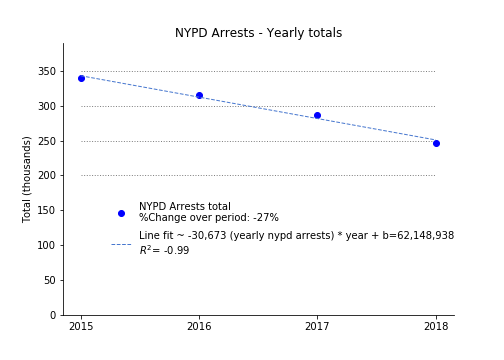

In [427]:
Image(filename=fig1)

---
# Q2

In [428]:
Questions['Q2']
print("Compare & describe the overall trends of these arrests across time.")

"What are the top 5 most frequent arrests as described in the column 'pd_desc' in 2018?"

Compare & describe the overall trends of these arrests across time.


In [166]:
# all yrs:
top5 = DATA_INTERIM.joinpath(ID_Arrests + '_top5_desc.csv')
top5_2018 = DATA_INTERIM.joinpath(ID_Arrests + '_top5_desc_2018.csv')
top5_2017 = DATA_INTERIM.joinpath(ID_Arrests + '_top5_desc_2017.csv')
top5_2016 = DATA_INTERIM.joinpath(ID_Arrests + '_top5_desc_2016.csv')
top5_2015 = DATA_INTERIM.joinpath(ID_Arrests + '_top5_desc_2015.csv')

# Save count of each 2018 top5 desc item grouped by year:
top5_evol = DATA_INTERIM.joinpath(ID_Arrests + '_top5_desc_evol.csv')

top5_evol_final = DATA_READY.joinpath(ID_Arrests + '_top5_desc_evol.csv')

top5_evol_rankings = DATA_READY.joinpath(ID_Arrests + '_top5_desc_evol_rankings.csv')

---

In [65]:
# overall top5:

etl.load_xtab_df(top5, colindex_name='(2015-2018)', idx_col=None)

(2015-2018),pd_desc,count
0,"MARIJUANA, POSSESSION 4 & 5",422358
1,ASSAULT 3,376001
2,"THEFT OF SERVICES, UNCLASSIFIED",303359
3,"CONTROLLED SUBSTANCE, POSSESSION 7",278083
4,"NY STATE LAWS,UNCLASSIFIED VIOLATION",225678


## These Top 5 arrests in 2018 will be traced over time in the 2015-2018 period:

In [66]:
df_top5_18 = etl.load_xtab_df(top5_2018, colindex_name=2018, idx_col=None)
df_top5_18

2018,pd_desc,count
0,ASSAULT 3,26611
1,"LARCENY,PETIT FROM OPEN AREAS,UNCLASSIFIED",23405
2,"TRAFFIC,UNCLASSIFIED MISDEMEAN",14856
3,"ASSAULT 2,1,UNCLASSIFIED",11763
4,"CONTROLLED SUBSTANCE, POSSESSION 7",9982


In [67]:
df_top5_15 = etl.load_xtab_df(top5_2015, colindex_name=2015, idx_col=None)
df_top5_15

2015,pd_desc,count
0,"THEFT OF SERVICES, UNCLASSIFIED",29833
1,ASSAULT 3,27631
2,"LARCENY,PETIT FROM OPEN AREAS,UNCLASSIFIED",25772
3,"CONTROLLED SUBSTANCE, POSSESSION 7",17420
4,"NY STATE LAWS,UNCLASSIFIED VIOLATION",16899


#### How the Top 5 arrests in 2018 have evolved over the years (2015-2018):

In [24]:
evol_stats = etl.get_evol_stats(top5_evol_final)
evol_stats

{'min_delta_desc': 'CONTROLLED SUBSTANCE, POSSESSION 7',
 'min_delta': -0.43,
 'max_delta_desc': 'TRAFFIC,UNCLASSIFIED MISDEMEAN',
 'max_delta': 0.03,
 'count_decreasing_delta': 4,
 'count_delta_above_5pct': 2,
 'min_std_desc': 'ASSAULT 2,1,UNCLASSIFIED',
 'min_std': 160.02369616195386,
 'max_std_desc': 'CONTROLLED SUBSTANCE, POSSESSION 7',
 'max_std': 3138.0850848885534,
 'min_max_std_fold': 20.0}

In [26]:
df_evol = etl.load_xtab_df(top5_evol_final)
df_evol

,2015,2016,2017,2018,%change
ASSAULT 3,27631.0,26961.0,26281.0,26611.0,-0.04
"LARCENY,PETIT FROM OPEN AREAS,UNCLASSIFIED",25772.0,23871.0,23020.0,23405.0,-0.09
"TRAFFIC,UNCLASSIFIED MISDEMEAN",14435.0,15231.0,16298.0,14856.0,0.03
"ASSAULT 2,1,UNCLASSIFIED",12048.0,12127.0,11911.0,11763.0,-0.02
"CONTROLLED SUBSTANCE, POSSESSION 7",17420.0,14177.0,12341.0,9982.0,-0.43


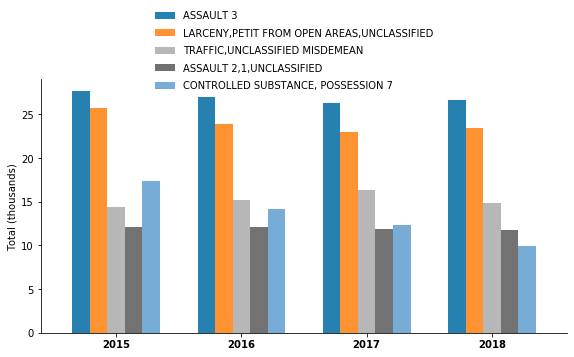

In [22]:
fig2 = DIR_IMG.joinpath(ID_Arrests + '_Top5_2018_evol.png')

fsize = (8,5)
fig, ax = plt.subplots(1, 1, figsize=fsize)

# clip the delta_pct col, transpose & get bar plot
df_evol_bar = df_evol.loc[:, df_evol.columns[:-1]].T

bbox = (0.2, .92, 0.7, .1)
#mode = 'expand'

# bypass saving in func with savepic=False.
# to fing out which padding works best in layout
ax = etl.show_bar_plot(df_evol_bar, ax, fname=fig2, 
                       lgd_bbox=bbox, 
                       savepic=False, replace=True, alpha=0.85, width=.70);
                       
plt.tight_layout(pad=.8)
etl.save_pic(plt, fname=fig2, transparent=True, replace=True)

plt.show();

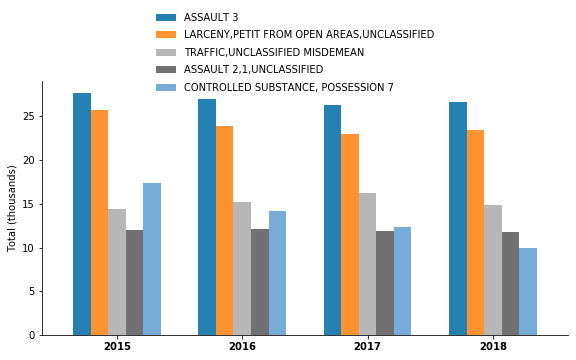

In [23]:
Image(filename=fig2)

## Evolution of all yearly Top5 arrests

In [25]:
df_evol = etl.load_xtab_df(top5_evol_final)
df_evol

,2015,2016,2017,2018,%change
ASSAULT 3,27631.0,26961.0,26281.0,26611.0,-0.04
"LARCENY,PETIT FROM OPEN AREAS,UNCLASSIFIED",25772.0,23871.0,23020.0,23405.0,-0.09
"TRAFFIC,UNCLASSIFIED MISDEMEAN",14435.0,15231.0,16298.0,14856.0,0.03
"ASSAULT 2,1,UNCLASSIFIED",12048.0,12127.0,11911.0,11763.0,-0.02
"CONTROLLED SUBSTANCE, POSSESSION 7",17420.0,14177.0,12341.0,9982.0,-0.43


In [162]:
df_top5_ranks = etl.load_xtab_df(top5_evol_rankings)

n_common_desc = df_top5_ranks.shape[0]
text = f'<h4>There are {n_common_desc} types of arrests appearing among the Top 5 yearly rankings.</h4>'
Markdown(text)

df_top5_ranks_styl = etl.top5_style(df_top5_ranks)
display(df_top5_ranks_styl)

<h4>There are 8 types of arrests appearing among the Top 5 yearly rankings.</h4>

,2015,2016,2017,2018
Arrests description in any yearly Top 5 ranking,,,,
ASSAULT 3,"2nd: 27,631","2nd: 26,961","1st: 26,281","1st: 26,611"
"LARCENY,PETIT FROM OPEN AREAS,UNCLASSIFIED","3rd: 25,772","3rd: 23,871","2nd: 23,020","2nd: 23,405"
"TRAFFIC,UNCLASSIFIED MISDEMEAN",,"5th: 15,231","5th: 16,298","3rd: 14,856"
"ASSAULT 2,1,UNCLASSIFIED",,,,"4th: 11,763"
"CONTROLLED SUBSTANCE, POSSESSION 7","4th: 17,420",,,"5th: 9,982"
"THEFT OF SERVICES, UNCLASSIFIED","1st: 29,833","1st: 27,234","3rd: 19,825",
"MARIJUANA, POSSESSION 4 & 5",,"4th: 18,117","4th: 17,964",
"NY STATE LAWS,UNCLASSIFIED VIOLATION","5th: 16,899",,,


---
### Arrests per precincts:
1. all years
2. period years

In [329]:
# problem recovering mutiindex df from csv:
arrests_totals = DATA_READY.joinpath(ID_Arrests + '_precincts_arrests_tots.csv')

# saved as pic for report:
fig_arrests_tos = DIR_IMG.joinpath(ID_Arrests + '_arrests_totals.png')

In [359]:
df = get_precincts_totals(arrests_totals)  # done

# HACK: saved as png, IMG/8h9b-rp9u_arrests_totals.png: CTL+ALT+PrtScr > Paint
etl.big_int_style(df)

In [202]:
Questions['Q3']

'If we think of arrests as a sample of total crime, is there more crime in precinct 19 (Upper East Side) than precinct 73 (Brownsville)?'

In [399]:
df_pop = etl.load_xtab_df(pops)
df_pop
nyc_pop = 8175133
# https://www1.nyc.gov/assets/planning/download/pdf/data-maps/nyc-population/census2010/pgrhc.pdf

,borough,cd_number,cd_name,pop_2010
0,Manhattan,8,Upper East Side,219920
1,Brooklyn,16,"Brownsville, Ocean Hill",86468


In [362]:
tots = etl.load_arrests_totals(arrests_totals)
tots

,all years,last 4
Precincts,,
19,40996.0,10946.0
73,134086.0,28500.0
all,4798119.0,1187263.0


In [391]:
# tot for the 2 precincts:
tot_2precs_all = tots['all years'].sum() - tots.loc['all', 'all years']
tot_2precs_4y = tots['last 4'].sum() - tots.loc['all', 'last 4']

pct_tot_arrests_all = tots.loc[['19','73'], 'all years'] / tot_2precs_all
pct_tot_arrests_all
pct_tot_arrests_4y = tots.loc[['19','73'], 'last 4'] / tot_2precs_4y
pct_tot_arrests_4y

Precincts
19    0.234153
73    0.765847
Name: all years, dtype: float64

Precincts
19    0.277493
73    0.722507
Name: last 4, dtype: float64

In [397]:
pop_pct = df_pop.pop_2010/df_pop.pop_2010.sum()
pop_pct
pct_tot_arrests_all

0    0.717783
1    0.282217
Name: pop_2010, dtype: float64

Precincts
19    0.234153
73    0.765847
Name: all years, dtype: float64

In [383]:
nyc_pop = 8175133
# https://www1.nyc.gov/assets/planning/download/pdf/data-maps/nyc-population/census2010/pgrhc.pdf

df_pop = etl.load_xtab_df(pops)
tots = etl.load_arrests_totals(arrests_totals)
tots

p19_tot_all_pct = tots.loc['19', 'all years'] / tots.loc['all', 'all years']
p19_tot_4y_pct = tots.loc['19', 'last 4'] / tots.loc['all', 'last 4']

p73_tot_all_pct = tots.loc['73', 'all years'] / tots.loc['all', 'all years']
p73_tot_4y_pct = tots.loc['73', 'last 4'] / tots.loc['all', 'last 4']

p73_tot_all_pct/p19_tot_all_pct
p73_tot_4y_pct/p19_tot_4y_pct

pop19cd = df_pop.loc[0,'pop_2010']
pop73cd = df_pop.loc[1,'pop_2010']
pop19cd /pop73cd

text = f'Precinct 19 accounts for less than 1% of all crimes and of those in the last'
text += f'four years ({p19_tot_all_pct:.2%} and {p19_tot_4y_pct:.2%}, respectively)<br> while '
text += f'the percentages for Precinct 79 are {p73_tot_all_pct:.2%} and {p73_tot_4y_pct:.2%}, '
text += 'i.e. over twice as much. As the population of Community District 8, <br>where Precinct 19 resides, ' 
text += 'is slightly over 2.5 larger than that of CD 16, where Precinct 73 is located, this is not a population effect:<br>'
text += 'there is more crime in Precinct 73 than in Precinct 19.'
Markdown(text)

Precinct 19 accounts for less than 1% of all crimes and of those in the lastfour years (0.85% and 0.92%, respectively)<br> while the percentages for Precinct 79 are 2.79% and 2.40%, i.e. over twice as much. As the population of Community District 8, <br>where Precinct 19 resides, is slightly over 2.5 larger than that of CD 16, where Precinct 73 is located, this is not a population effect:<br>there is more crime in Precinct 73 than in Precinct 19.

In [389]:
df_pop.pop_2010/df_pop.pop_2010.sum()
df_pop.pop_2010 / nyc_pop
df_pop.pop_2010.sum() / nyc_pop

0    0.717783
1    0.282217
Name: pop_2010, dtype: float64

0    0.026901
1    0.010577
Name: pop_2010, dtype: float64

0.03747804469970091

In [386]:
Questions['Q4']

'Given the available data, what model would you build to predict crime to better allocate NYPD resources?'

In [419]:
s = """  Predicitve crime modelling is an active area of research due to its data, design and ethical challenges.  
These spatio-temporal models have stringent requirements for their effectiveness: For the purpose of allocating patrol officers to areas<br>
in need in a timely fashion, the model would need to predict the locations (within a reasonable distance variability) _together with_ a long enough <br>
"time-ahead" window. For instance a model capable of predicting crime hot-spot at the block level would be useless if it could not do so _at least_ <br>
48 hours prior the predicted activity. As the _NYPD Arrests Data_ dataset does not have time data, other sources, such as 911 call logs, would be needed.<br>  
Part of the data challenge is to decide which input data to use: while weather and "crowd signals" from social media are probably useful, the use of <br>
socio-economic data may introduce bias.
  The more varied the sources, the wider the skills needed to process and anlyze the data as they take many <br>
forms: text, sound, video, etc.  Part of the modeling challenge is to identify which features are necessary to achieve a given goal. In this context, the <br>
minimal type of information is location, date and time and the age-group distibutions (at the census tract level if possible) since the 24-44 age group <br>
is the most represented in the dataset.  Whether the model is parametric (i.e. regression) or neural (machine learning), the first step is to establish a <br>
baseline against which other models (issued from different feature selection, for example) will be rated."""
Markdown(s)

  Predicitve crime modelling is an active area of research due to its data, design and ethical challenges.  
These spatio-temporal models have stringent requirements for their effectiveness: For the purpose of allocating patrol officers to areas<br>
in need in a timely fashion, the model would need to predict the locations (within a reasonable distance variability) _together with_ a long enough <br>
"time-ahead" window. For instance a model capable of predicting crime hot-spot at the block level would be useless if it could not do so _at least_ <br>
48 hours prior the predicted activity. As the _NYPD Arrests Data_ dataset does not have time data, other sources, such as 911 call logs, would be needed.<br>  
Part of the data challenge is to decide which input data to use: while weather and "crowd signals" from social media are probably useful, the use of <br>
socio-economic data may introduce bias.
  The more varied the sources, the wider the skills needed to process and anlyze the data as they take many <br>
forms: text, sound, video, etc.  Part of the modeling challenge is to identify which features are necessary to achieve a given goal. In this context, the <br>
minimal type of information is location, date and time and the age-group distibutions (at the census tract level if possible) since the 24-44 age group <br>
is the most represented in the dataset.  Whether the model is parametric (i.e. regression) or neural (machine learning), the first step is to establish a <br>
baseline against which other models (issued from different feature selection, for example) will be rated.

In [408]:
len(s.split())

267

---

In [ ]:
#"https://data.cityofnewyork.us/resource/8h9b-rp9u.csv?$select=count(ARREST_KEY),PD_DESC&$where=date_extract_y(ARREST_DATE)='2018'&$group=PD_DESC&$order=count(ARREST_KEY)%20DESC&$limit=5")
